# About the Dataset

### Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

### Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Used for viewing Dataframes
import dtale

# ML Prediction Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import optuna
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings("ignore")

### Viewing the data
Using .info(), we can see that there are no (directly) null values in our dataset. As for the data types, we should investigate why TotalCharges has type object instead of float.

In [3]:
# Import data
file_path = "telco_customer_churn.csv"
telco_data = pd.read_csv(file_path)

print(telco_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Viewing the columns with object data type
As expected, TotalCharges should be convereted to a float. Also, there are several columns with non-boolean data types being used to describe a binary categorical feature. These can be converted to boolean True/False columns for easier modelling.

In [5]:
object_columns = telco_data.select_dtypes(include=['object'])

for col in object_columns.columns:
    print(f"{col} - {object_columns[col].nunique()} Unique Values")
    print(object_columns[col].unique())
    print()

# Convert Yes/No object columns to bool True/False
cols_to_convert = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in cols_to_convert:
    telco_data[col] = telco_data[col].map({'Yes': True, 'No': False}).astype(bool)

# Convert int 1/0 SeniorCitizen column to bool True/False
telco_data['SeniorCitizen'] = telco_data['SeniorCitizen'].map({1: True, 0: False}).astype(bool)

# Relocate Churn (column  of interest) to front of dataframe for clarity
telco_data.insert(0, 'Churn', telco_data.pop('Churn'))

# Remaining object columns
object_columns = telco_data.select_dtypes(include=['object'])
print("\nRemaining object columns after boolean conversions:")
print(object_columns.columns)

customerID - 7043 Unique Values
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender - 2 Unique Values
['Female' 'Male']

Partner - 2 Unique Values
['Yes' 'No']

Dependents - 2 Unique Values
['No' 'Yes']

PhoneService - 2 Unique Values
['No' 'Yes']

MultipleLines - 3 Unique Values
['No phone service' 'No' 'Yes']

InternetService - 3 Unique Values
['DSL' 'Fiber optic' 'No']

OnlineSecurity - 3 Unique Values
['No' 'Yes' 'No internet service']

OnlineBackup - 3 Unique Values
['Yes' 'No' 'No internet service']

DeviceProtection - 3 Unique Values
['No' 'Yes' 'No internet service']

TechSupport - 3 Unique Values
['No' 'Yes' 'No internet service']

StreamingTV - 3 Unique Values
['No' 'Yes' 'No internet service']

StreamingMovies - 3 Unique Values
['No' 'Yes' 'No internet service']

Contract - 3 Unique Values
['Month-to-month' 'One year' 'Two year']

PaperlessBilling - 2 Unique Values
['Yes' 'No']

PaymentMethod - 4 Unique Values
['Electronic check' 'Mai

### Converting TotalCharges
When I originally attempted to convert TotalCharges from string to float, I got an error saying that ' ' cannot be converted to float. Looking at the rows where this is the case, it seems that they are customers who have a subscription plan but are still in their first month so they haven't been charged yet. We can simply replace the empty strings with '0' and convert to float. Using .describe(), we can see that the conversion was a success.

In [7]:
telco_data['TotalCharges'] = telco_data['TotalCharges'].replace(' ', '0').astype(float)

print(telco_data['TotalCharges'].describe())

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


### Encoding Categorical Variables
We can simply encode our categorical variables using pd.get_dummies(). Considering encoded_telco_data will be used to determine the relationship between features and the target variable, we do not need to keep track of the customer IDs.

In [9]:
object_columns = telco_data.select_dtypes(include=["object"])
object_columns = object_columns.drop(columns="customerID")

encoded_object_columns = pd.get_dummies(object_columns)
encoded_telco_data = pd.concat([telco_data.drop(columns=object_columns), encoded_object_columns], axis=1)

# Don't need customer IDs or Contract in encoded dataframe
encoded_telco_data = encoded_telco_data.drop(columns=["customerID"])

### Correlation Matrix - Heatmap
Looking at the heatmap below, there are a few relationships that immediately stand out.
1. "TotalCharges" is very positively correlated with "tenure", which intuitively makes sense.
2. "gender_Male" and "gender_Female" are directly negatively correlated. Again, this makes sense as only one of the two can be true at once.
3. The customer's gender has little to no correlation with any of the features, as seen by the two-pixel wide grey lines accross the heatmap.
4. The same relationship can be found between "MultipleLine_No Phone Service" and "PhoneService".
5. All 7 features containing "No internet service" are directly correlated as they have to be either all True or all False for a given customer.

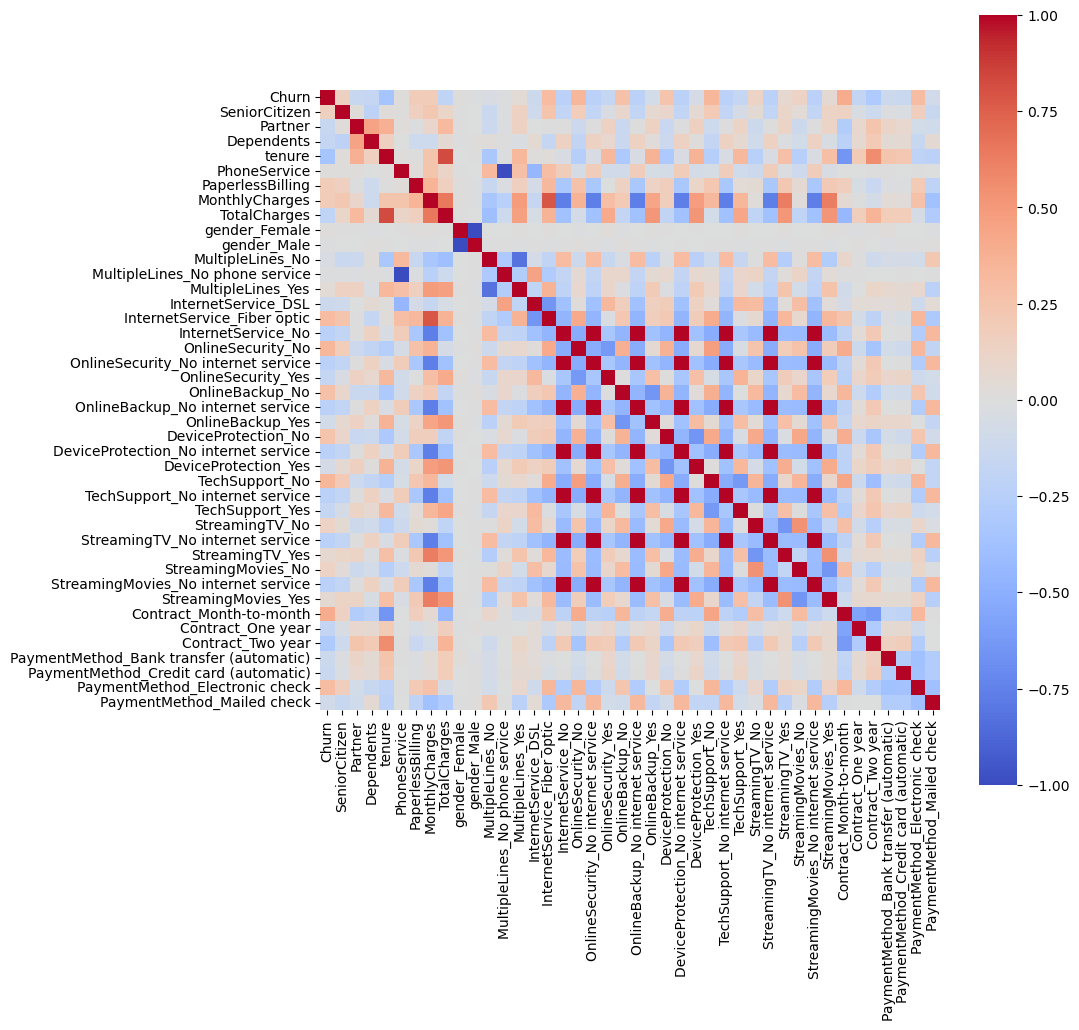

<Figure size 640x480 with 0 Axes>

In [11]:
# Correlation matrix
corr_mat = encoded_telco_data.corr()

f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, cmap='coolwarm', square=True)
plt.show()
plt.clf()

### Feature Correlation with Churn
Before continuing, let's focus on the correlation of our features with our target variable "Churn".

The feature most negatively correlated with "Churn" is "tenure". This intuitively makes sense; The longer someone is with the company, the more likely they are to be satisfied with their services and don't see a need to switch.

The feature most positively correlated with "Churn" is "Contract_Month-to-month" which also intuitively makes sense. People who pay month-to-month can leave at any time and customers trying the service for the first time would likely sign this contract.

As we saw from the heatmap, all features containing "no internet service" are redundant. Of the 7 features, we will keep the original "InternetService_No".

For the positively correlated features, some of the features can be paired together with very similar correlation strengths. These pairs are:
- StreamingTV_No and StreamingMovies_No
- PaperlessBilling and MonthlyCharges
  
The correlation strengths are so close that it is worth checking their correlation to each other. If they are directly correlated (correlation of 1), we can remove one feature from each pair. Otherwise, they can all remain. Viewing the values directly from the correlation matrix, each pair has a correlation of 0.54 and 0.35, respectively. So, the features are not directly correlated and each provide valuable information.

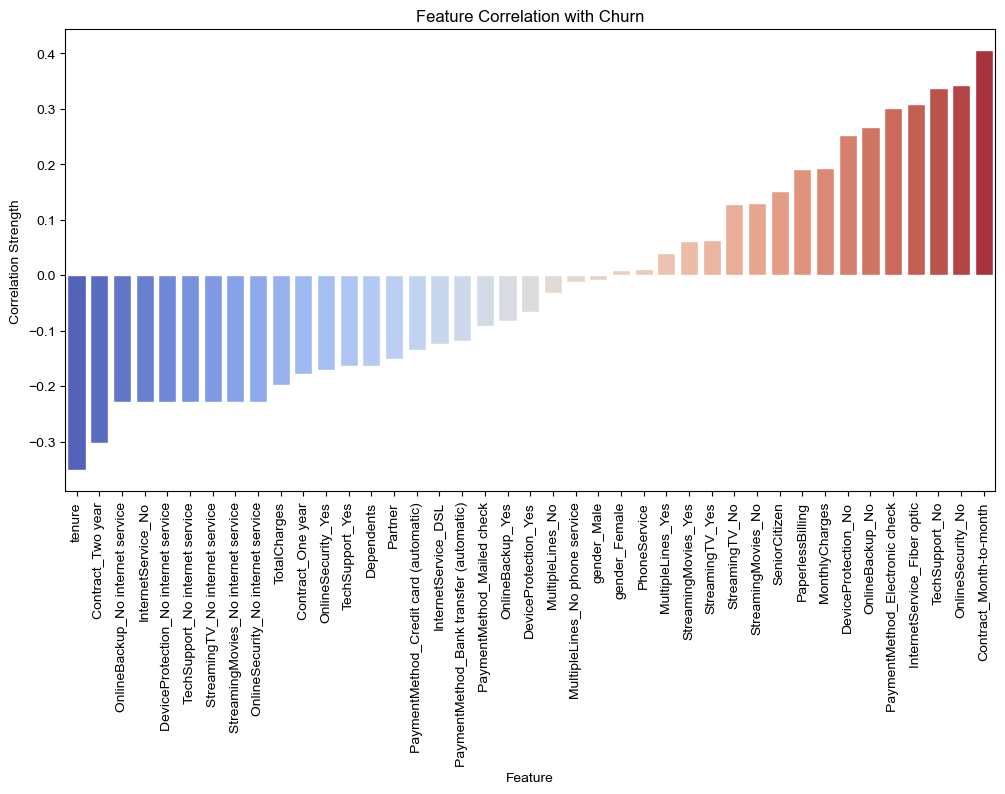

<Figure size 640x480 with 0 Axes>

In [13]:
# Isolate features
features_df = encoded_telco_data.drop(columns='Churn')

# Creating dataframe containing the correlation of each feature with our target variable
feature_target_corr = pd.DataFrame({'feature': features_df.columns, 'correlation': corr_mat['Churn'][1:]})
feature_target_corr = feature_target_corr.sort_values(by='correlation')

# Plot positive values in red and negative values in blue
f, ax = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")
sns.barplot(data=feature_target_corr,
            x='feature', 
            y='correlation', 
            palette='coolwarm')

plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Correlation Strength')
plt.title('Feature Correlation with Churn')
plt.show()
plt.clf()

In [15]:
print(f"Correlation between StreamingTV_No and StreamingMovies_No: " + str(corr_mat["StreamingTV_No"]["StreamingMovies_No"]))
print(f"Correlation between PaperlessBilling and MonthlyCharges: " + str(corr_mat["PaperlessBilling"]["MonthlyCharges"]))

cols_to_drop = [col for col in encoded_telco_data if "No internet service" in col]
encoded_telco_data = encoded_telco_data.drop(columns=cols_to_drop)

Correlation between StreamingTV_No and StreamingMovies_No: 0.5377730397498407
Correlation between PaperlessBilling and MonthlyCharges: 0.35214996779598723


## Plotting 
Now that our data is cleaned and we have a separate encoded dataframe for machine learning purposes, let's take a closer look at what we're dealing with.

In [17]:
# Ensure all changes we've done so far have been saved
print(telco_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7043 non-null   bool   
 1   customerID        7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   bool   
 4   Partner           7043 non-null   bool   
 5   Dependents        7043 non-null   bool   
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   bool   
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


### Count Plots
Below are count plots for all categorical variables, allowing us to visually inspect the distributions for every feature.

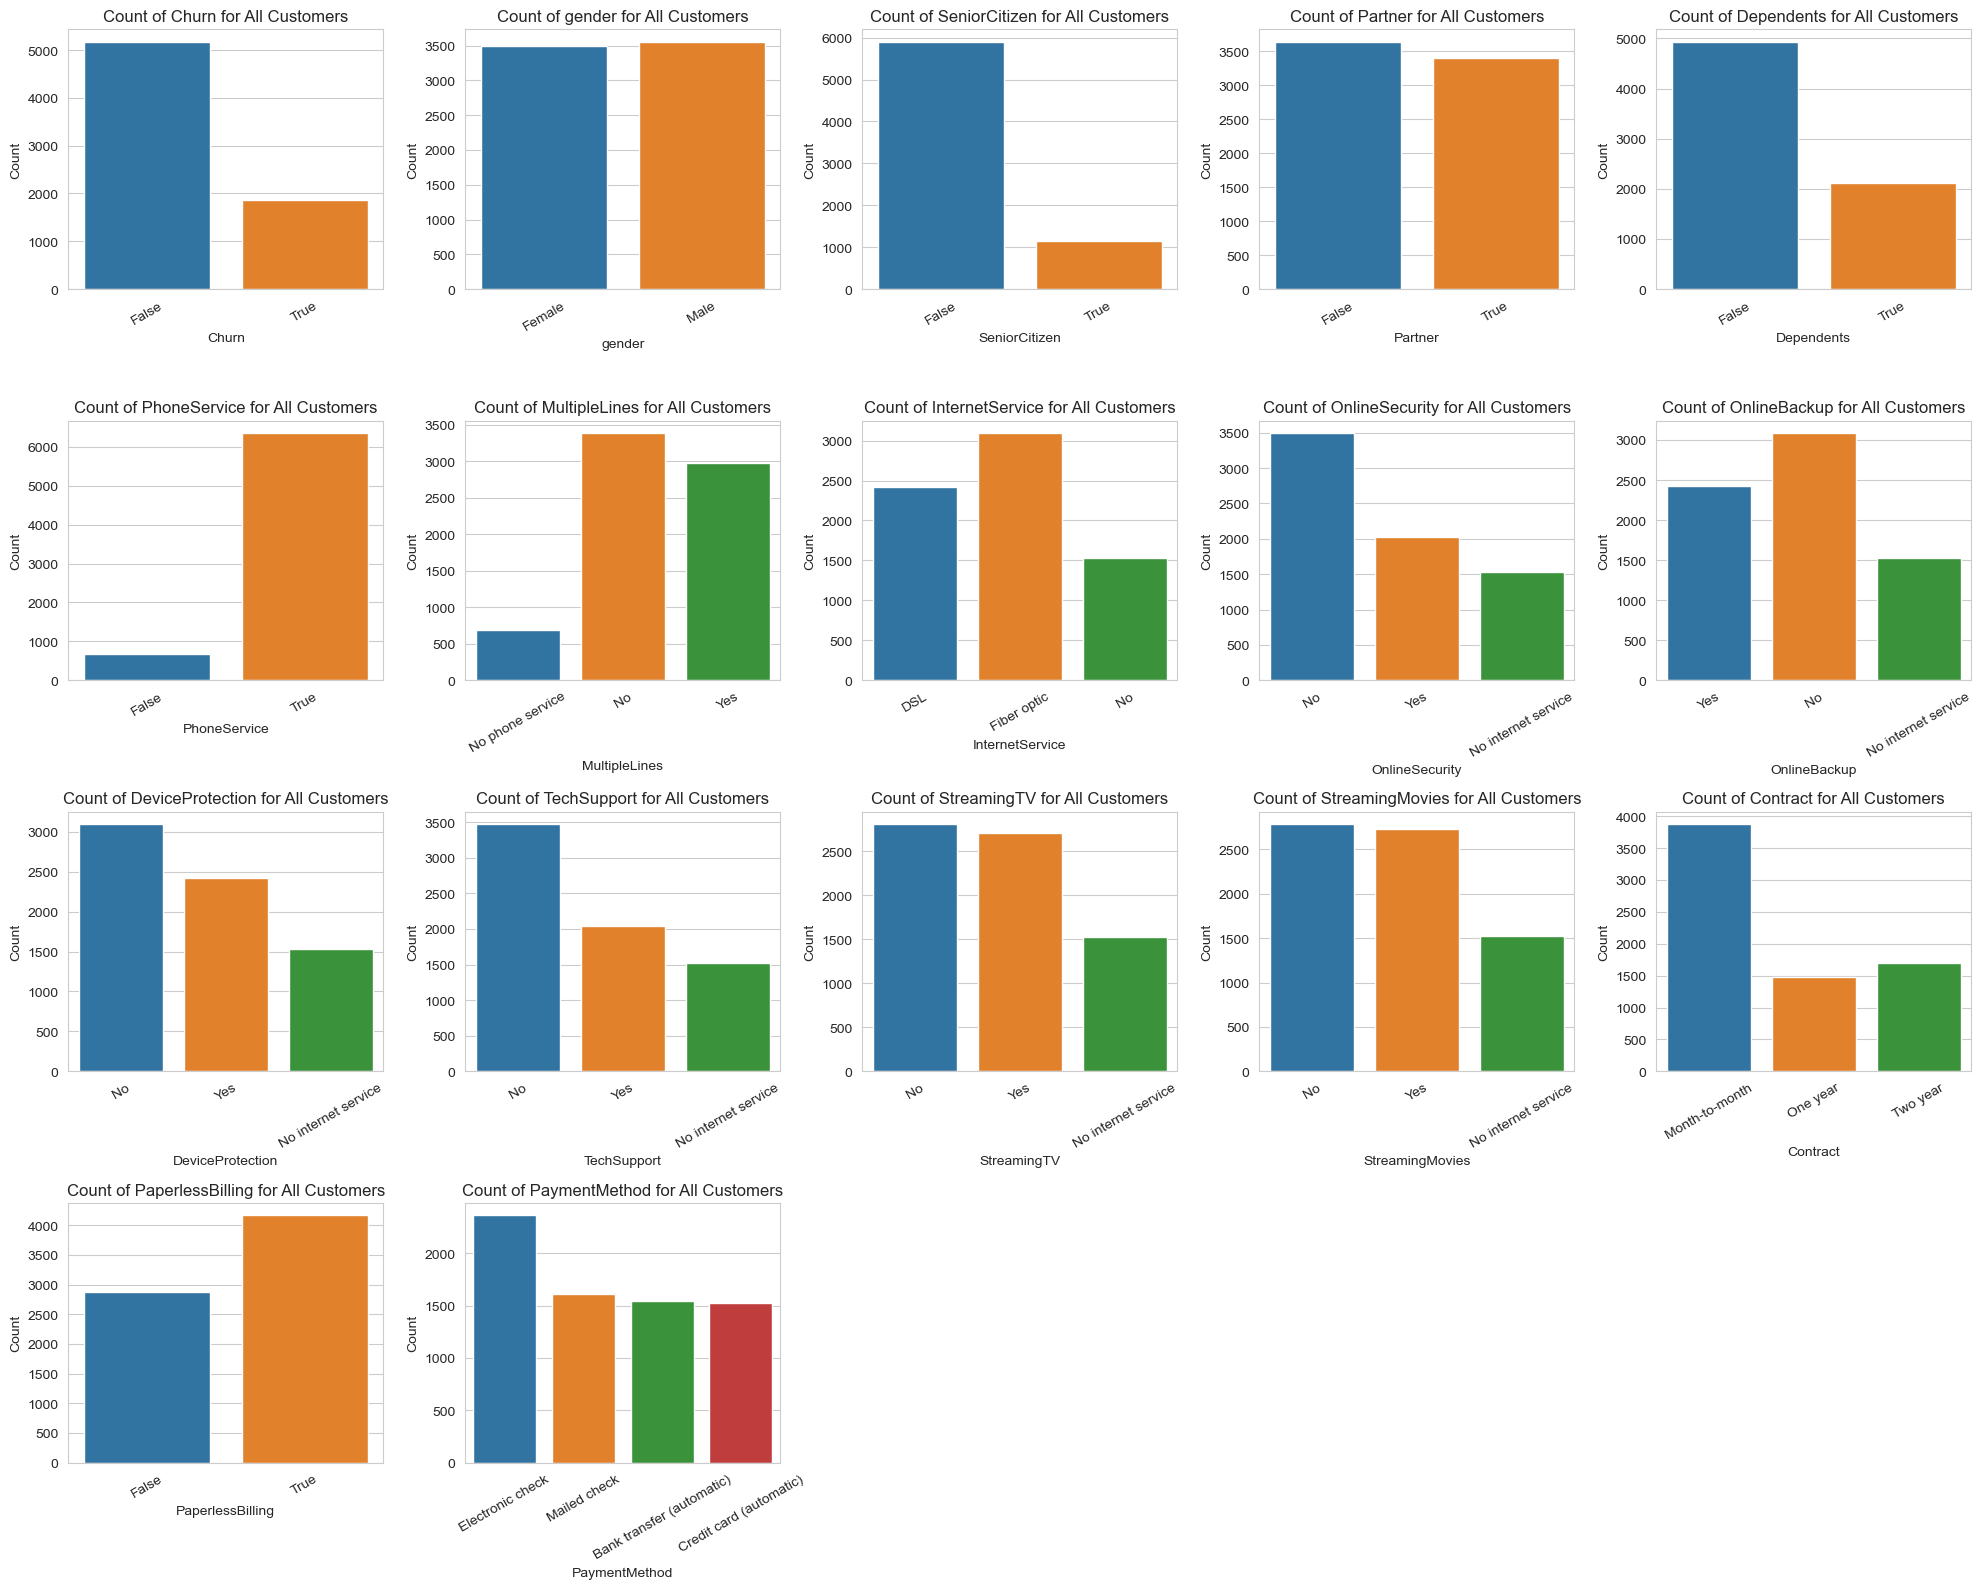

<Figure size 640x480 with 0 Axes>

In [19]:
telco_countplots = telco_data.copy()
telco_countplots = telco_data.select_dtypes(exclude=[int, float])
telco_countplots.drop(columns=["customerID"], inplace=True)

f, ax = plt.subplots(4, 5, figsize=(20, 16))
ax = ax.flatten()

for i, col in enumerate(telco_countplots.columns):
    sns.countplot(data=telco_countplots, x=col, ax=ax[i])
    ax[i].set_title(f'Count of {col} for All Customers')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

    # Set and rotate x-axis labels
    ax[i].tick_params(axis='x', rotation=30)

# Hide empty subplots if the number of columns is less than 20
for ax in ax[len(telco_countplots.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
plt.clf()

### Percent Distributions
A better plot to compare distributions of the churned/non-churned customers is to use their percent distributions rather than sample count. With this, we can see any discrepencies between the two distributions and identify possible correlations.

For example:
- Over 80% of churned customers pay month-to-month, which is far more than the roughly 40% of non-churned customers. From this, we can conclude that there is a noticeable correlation between customers churning and paying month-to-month.
- The opposite relationship can be seen with customers who don't pay for internet service. The percent distribution for churned customers is lower than the distribution of non-churned customers.
- The percent distribution of genders are nearly identical between both subsets, showing no significant correlation between the gender of the customer and whether or not they will churn.

The conclusions that can be drawn from these distributions should also all be represented in the heatmap.

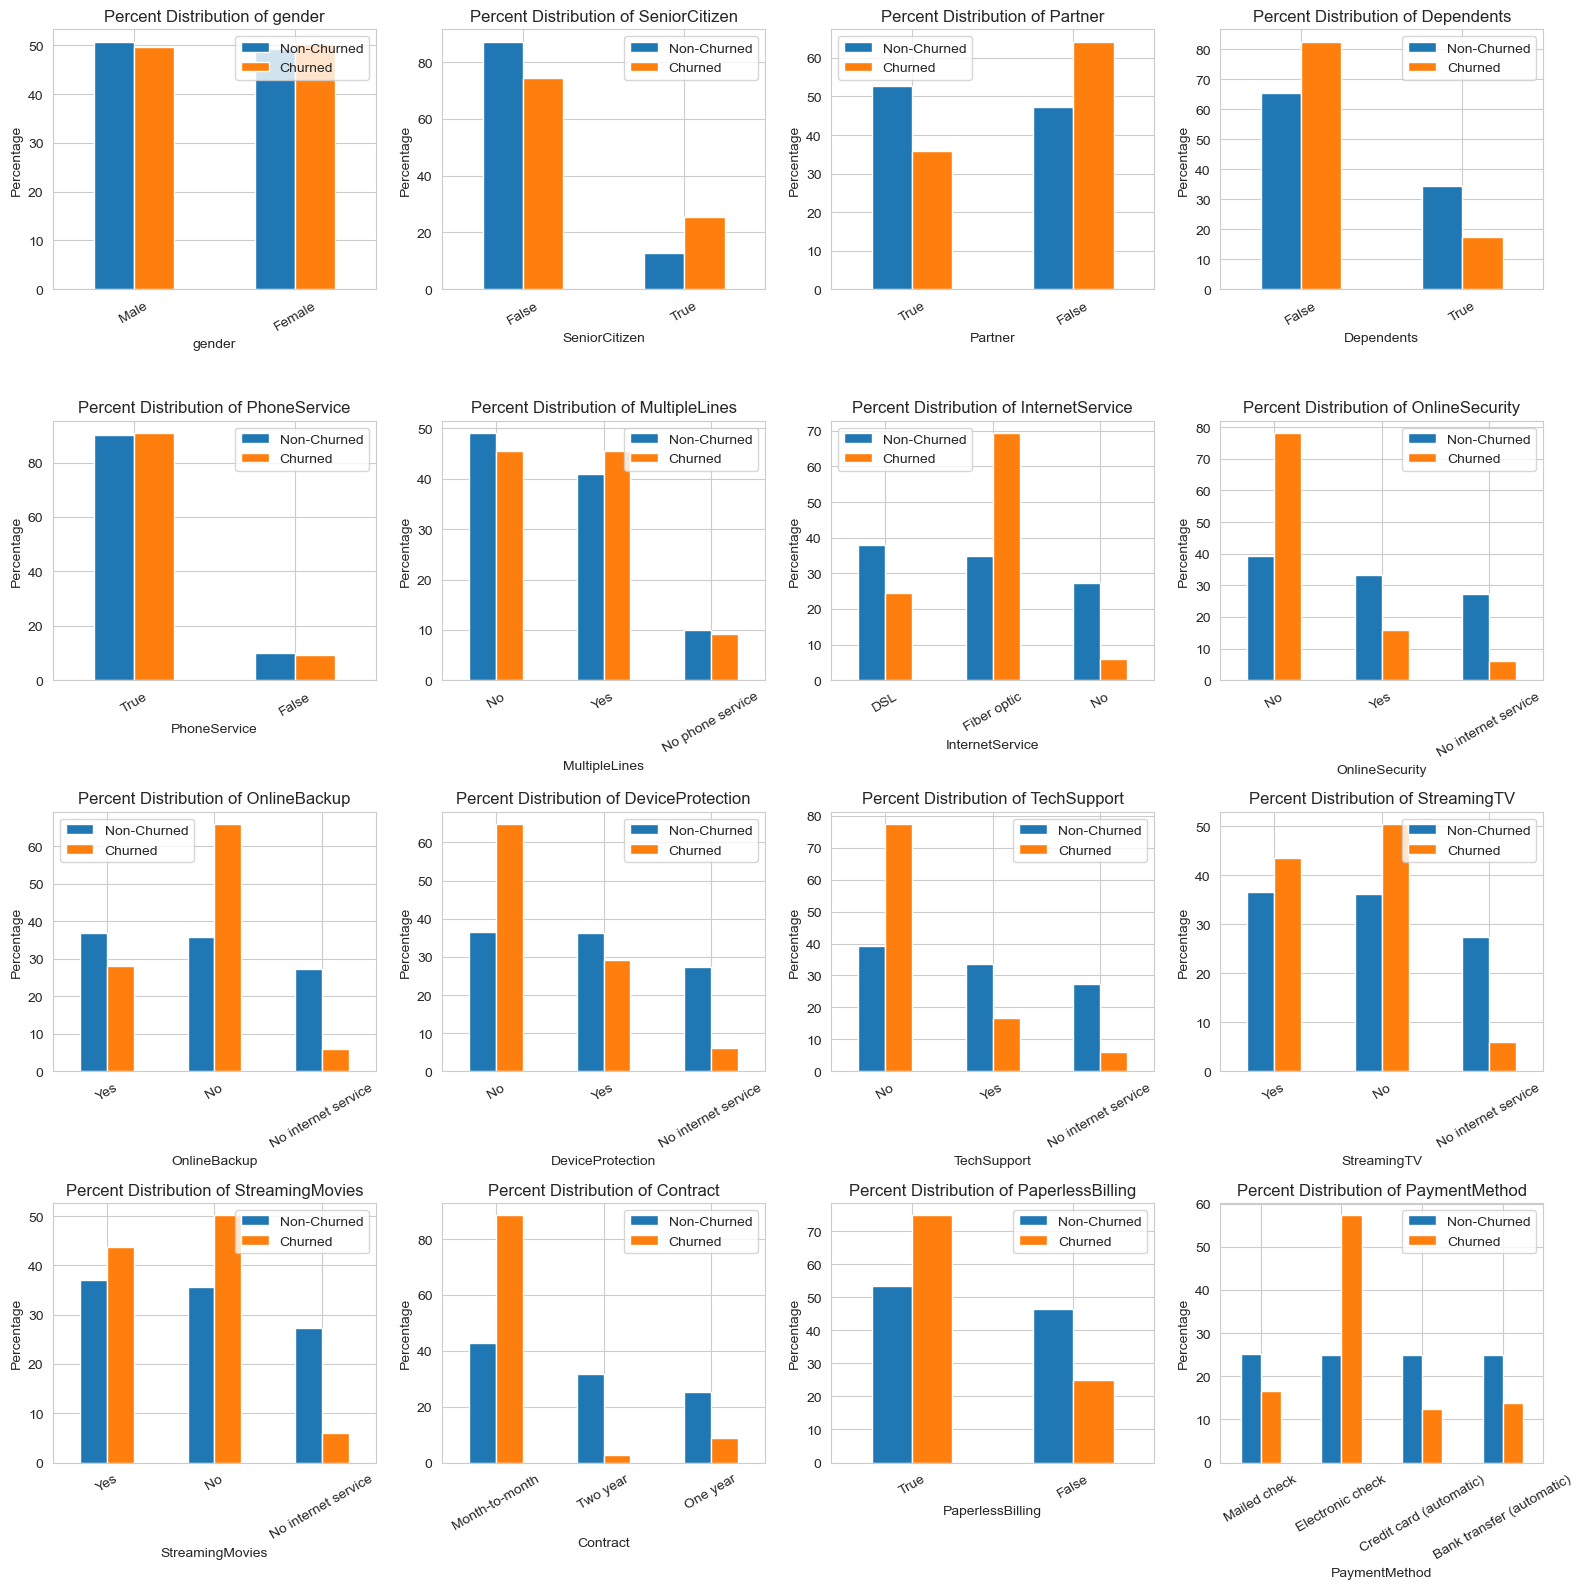

<Figure size 640x480 with 0 Axes>

In [21]:
telco_categorical = telco_data.select_dtypes(exclude=[int, float])
telco_categorical.drop(columns=["customerID"], inplace=True)

churn_categorical = telco_categorical[telco_categorical["Churn"] == True]
no_churn_categorical = telco_categorical[telco_categorical["Churn"] == False]

f, ax = plt.subplots(4, 4, figsize=(16, 16))
ax = ax.flatten()

for i, col in enumerate(telco_categorical.drop(columns="Churn").columns):
    # Create temporary dataframe
    telco_pct = pd.DataFrame()
    
    # Percent distribution of each variable for a given column for non-churned customers
    no_churn_pct = (100 * no_churn_categorical[col].value_counts()/no_churn_categorical.shape[0]).reset_index()
    no_churn_pct.rename(columns={"count": "Non-Churned"}, inplace=True)
    # Do the same for the subset of the population that have churned
    churn_pct = (100 * churn_categorical[col].value_counts()/churn_categorical.shape[0]).reset_index()
    churn_pct.rename(columns={"count": "Churned"}, inplace=True)

    # Merge the two dataframes
    telco_pct = pd.merge(no_churn_pct, churn_pct, on=col)

    # Plot
    telco_pct.plot.bar(x=col, ax=ax[i])
    ax[i].set_title(f'Percent Distribution of {col}')
    ax[i].set_ylabel('Percentage')

    # Set and rotate x-axis labels
    ax[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()
plt.clf()

### Numerical Variables

In [23]:
print(telco_data.describe())

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


### Pair Plots
This allows us to view the distributions and relationships between numerical variables. From the histograms on the diagonal, there are a few observations that can be made:

**Tenure \- Non-Churned**
- Two peaks: Very low tenure and very high. We could investigate which demographics belong to these peaks (if any). I would predict that senior citizens are less likely to change service providers. We could also compare the types of packages to tenure length and see if there's any correlation.

**Tenure \- Churned**
- One Peak: Very clear trend that the shorter the tenure, the stronger the correlation to churning.

**Monthly Charges \- All Samples**
- Three modes: \\$35, \\$50, \\$80. Likely similar to the default package prices available to customers with the most popular being the cheapest plan.

**Total Charges \- All Samples**
- Vast majority of customers have relatively low total charges. This makes sense as the total charge column is dependent on tenure and monthly charge.

There is a clear linear relationship between all variables with the exception of tenure vs MonthlyCharges.

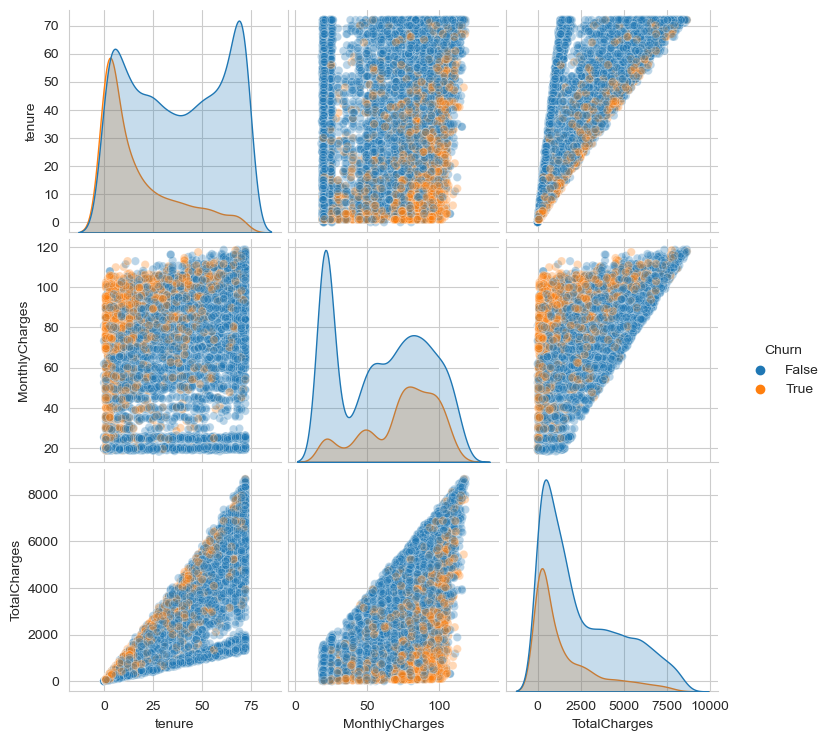

<Figure size 640x480 with 0 Axes>

In [25]:
telco_nums = telco_data.select_dtypes(include=[int, float])
telco_nums["Churn"] = telco_data["Churn"]

sns.pairplot(data=telco_nums, hue="Churn", plot_kws={'alpha': 0.3})
plt.show()
plt.clf()

We can more clearly see some of the relationships if we reduce the variation in possible monthly charges. We can see that for service plans cheaper than 35 dollars, the tenure and TotalCharges distributions have kept their shape but the MonthlyCharges values have fallen into more discrete modes with plans varying by roughly 5 dollars.

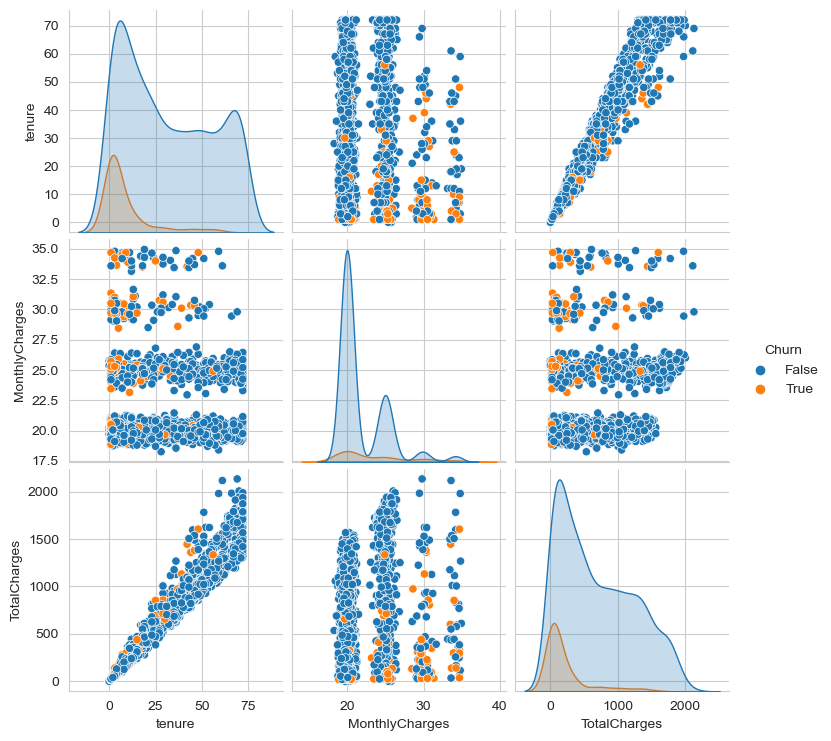

<Figure size 640x480 with 0 Axes>

In [27]:
telco_less_than_35 = telco_nums[telco_nums["MonthlyCharges"] < 35]

sns.pairplot(data=telco_less_than_35, hue="Churn")
plt.show()
plt.clf()

### Summary Statistics of Customers

In [29]:
print("Summary Statistics of Non-Churned Customers")
print(telco_nums[telco_nums["Churn"] == False].describe())

print("\nSummary Statistics of Churned Customers")
print(telco_nums[telco_nums["Churn"] == True].describe())

Summary Statistics of Non-Churned Customers
            tenure  MonthlyCharges  TotalCharges
count  5174.000000     5174.000000   5174.000000
mean     37.569965       61.265124   2549.911442
std      24.113777       31.092648   2329.954215
min       0.000000       18.250000      0.000000
25%      15.000000       25.100000    572.900000
50%      38.000000       64.425000   1679.525000
75%      61.000000       88.400000   4262.850000
max      72.000000      118.750000   8672.450000

Summary Statistics of Churned Customers
            tenure  MonthlyCharges  TotalCharges
count  1869.000000     1869.000000   1869.000000
mean     17.979133       74.441332   1531.796094
std      19.531123       24.666053   1890.822994
min       1.000000       18.850000     18.850000
25%       2.000000       56.150000    134.500000
50%      10.000000       79.650000    703.550000
75%      29.000000       94.200000   2331.300000
max      72.000000      118.350000   8684.800000


### Box Plots
These box plots act as a visual aide for the statistics above. Once again we can see that there is a noticeable difference between the tenure distributions of churned and unchurned customers (churned customers generally have shorter tenure). Churned customers generally pay more per month but have spent less in total. This makes sense as churned customers spend less time subscribed. 

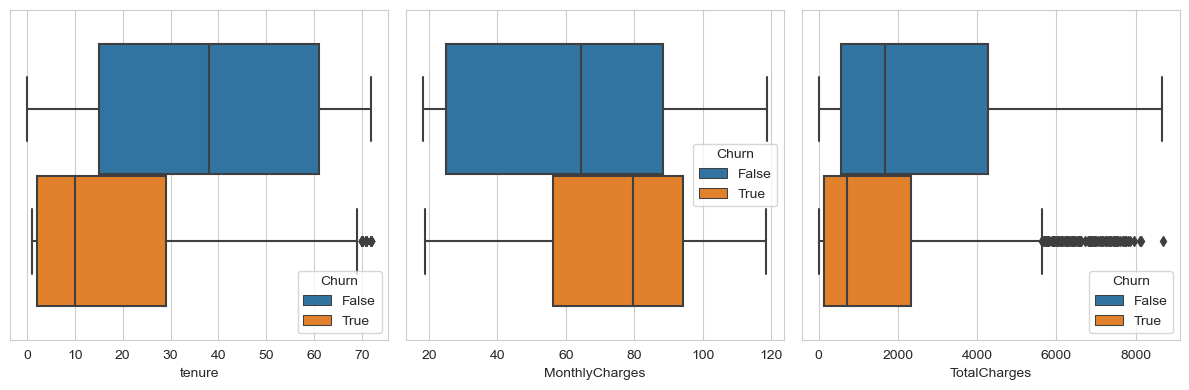

<Figure size 640x480 with 0 Axes>

In [31]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for i, col in enumerate(telco_nums.drop(columns="Churn").columns):
    sns.boxplot(data=telco_nums, x=col, y=np.array([""]* len(telco_nums)), hue="Churn", ax=ax[i])

plt.tight_layout()
plt.show()
plt.clf()

## Churn Predictive Modeling

We will look at 6 different training models:
1. Logistic Regression
2. Random Forest
3. K-Nearest Neighbors (KNN)
4. Gradient Boosting Classifier (GBC)
5. C-Support Vector Classification (SVC)
6. AdaBoost

### Hyperparameter Tuning with Optuna
A simple way to determine a potentailly good candidate to predict churn is to use Optuna. With Optuna, we can tune the hyperparameters of several models at once to optimize our desired metric score. In our case, we will tune our models to maximize F1 score.

As it stands, the highest F1 score achieved is 0.6, which is not very good. I suspect it has something to do with the severe imbalance of our target column.

In [33]:
# Using a robust scaler to better handle outliers
scaler = RobustScaler()
numerical_features = encoded_telco_data.select_dtypes(include=[int, float])
scaled_data = scaler.fit_transform(numerical_features)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numerical_features.columns)

# Adding it back to the encoded features
categorical_features = encoded_telco_data.select_dtypes(exclude=[int, float])
encoded_df = categorical_features.join(scaled_df)

#Split features and target column
X_data = encoded_df.drop(columns="Churn")
y_data = encoded_df["Churn"]

classifier_names = ["LogisticRegression", 
                    "RandomForestClassifier", 
                    "KNeighborsClassifier", 
                    "GradientBoostingClassifier", 
                    "SVC", 
                    "AdaBoostClassifier"]

# Optuna Hyperparameter Tuning

# Define an objective function to be maximized
def objective(trial):
    # Suggest values for the hyperparameters using a trial object
    classifier_name = trial.suggest_categorical("classifier", classifier_names)
    
    if classifier_name == "LogisticRegression":
        lr_c = trial.suggest_float("lr_c", 1e-2, 10, log=True)
        classifier_obj = LogisticRegression(C=lr_c)
    
    elif classifier_name == "RandomForestClassifier":
        rfc_max_depth = trial.suggest_int("rfc_max_depth", 2, 32, log=True)
        rfc_max_samples = trial.suggest_float("rfc_max_samples", 0.2, 1)
        classifier_obj = RandomForestClassifier(max_depth=rfc_max_depth, max_samples=rfc_max_samples, n_estimators=50)
    
    elif classifier_name == "KNeighborsClassifier":
        knc_n_neighbors = trial.suggest_int("knc_n_neighbors", 3, 10)
        classifier_obj = KNeighborsClassifier(n_neighbors=knc_n_neighbors)
        
    elif classifier_name == "GradientBoostingClassifier":
        gbc_learning_rate = trial.suggest_float("gbc_learning_rate", 1e-4, 1, log=True)
        classifier_obj = GradientBoostingClassifier(learning_rate=gbc_learning_rate)
    
    elif classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-2, 10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")
    
    else:
        abc_learning_rate = trial.suggest_float("abc_learning_rate", 1e-4, 1, log=True)
        classifier_obj = AdaBoostClassifier(learning_rate=abc_learning_rate)

    f1_score = cross_val_score(classifier_obj, X_data, y_data, cv=5, scoring="f1", n_jobs=-1).mean()
        
    return f1_score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_f1 = study.best_value

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1)

Best Hyperparameters: {'classifier': 'LogisticRegression', 'lr_c': 1.7088873313137642}
Best F1 Score: 0.5995368063666123


### Looking Closer at our Results
Recreating the optimal classifier above without Optuna, we can look at the confusion matrix as well as all the standard scoring metrics. As expected, there are a large amount of false negatives and false positives, causing our recall, precision, and F1 scores to suffer. We can also see the impact of having far more non-churned than churned customers in our dataset by the significant imbalance of false positives and false negatives. Due to the dataset having more negative target values, the model will overfit in that direction by predicting more falses than positives, causing more false negatives than false positives. One way to improve our model is to make our dataset more balanced. To do so, we can train our model on a resampled dataset using SMOTE Tomek.

In [35]:
def metric_report(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)
    
    print("Confusion Matrix")
    print(confusion_mat)
    print(f"\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

lr = LogisticRegression(C=best_params["lr_c"], max_iter=250)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

metric_report(y_test, y_pred)

Confusion Matrix
[[933 103]
 [149 224]]

Accuracy: 0.821
Precision: 0.685
Recall: 0.601
F1: 0.64


### Resampling with SMOTE Tomek
As we can see below, oversampling with SMOTE followed by undersampling with Tomek links has provided a perfectly balanced target column. Notice how the total dataset is larger due to the oversampling.

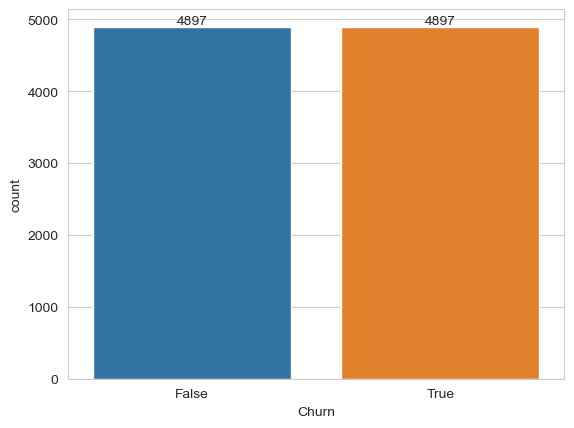

<Figure size 640x480 with 0 Axes>

In [37]:
# Resampling
resample = SMOTETomek(random_state=42)
X_res, y_res = resample.fit_resample(X_data, y_data)

ax = sns.countplot(x=y_res)
ax.bar_label(ax.containers[0])
plt.show()
plt.clf()

In [39]:
classifier_names = ["LogisticRegression", 
                    "RandomForestClassifier",
                    "KNeighborsClassifier",
                    "GradientBoostingClassifier", 
                    "SVC", 
                    "AdaBoostClassifier"]

# Optuna Hyperparameter Tuning

# Define an objective function to be maximized
def objective(trial):
    # Suggest values for the hyperparameters using a trial object
    classifier_name = trial.suggest_categorical("classifier", classifier_names)
    
    if classifier_name == "LogisticRegression":
        lr_c = trial.suggest_float("lr_c", 1e-2, 10, log=True)
        model = LogisticRegression(C=lr_c, max_iter=500)
    
    elif classifier_name == "RandomForestClassifier":
        rfc_max_depth = trial.suggest_int("rfc_max_depth", 2, 32, log=True)
        rfc_max_samples = trial.suggest_float("rfc_max_samples", 0.2, 1)
        model = RandomForestClassifier(max_depth=rfc_max_depth, max_samples=rfc_max_samples, n_estimators=50)
        
    elif classifier_name == "KNeighborsClassifier":
        knc_n_neighbors = trial.suggest_int("knc_n_neighbors", 3, 10)
        model = KNeighborsClassifier(n_neighbors=knc_n_neighbors)
        
    elif classifier_name == "GradientBoostingClassifier":
        gbc_learning_rate = trial.suggest_float("gbc_learning_rate", 1e-4, 1, log=True)
        model = GradientBoostingClassifier(learning_rate=gbc_learning_rate)
    
    elif classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-2, 10, log=True)
        model = SVC(C=svc_c, gamma="auto")
    
    else:
        abc_learning_rate = trial.suggest_float("abc_learning_rate", 1e-4, 1, log=True)
        model = AdaBoostClassifier(learning_rate=abc_learning_rate)

    model.fit(X_res, y_res)
    y_pred = model.predict(X_data)
    
    f1 = f1_score(y_data, y_pred)
        
    return f1

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_f1 = study.best_value

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1)

Best Hyperparameters: {'classifier': 'RandomForestClassifier', 'rfc_max_depth': 25, 'rfc_max_samples': 0.9602190132015052}
Best F1 Score: 0.9283652584623459


In [41]:
rfc = RandomForestClassifier(max_depth=best_params["rfc_max_depth"], max_samples=best_params["rfc_max_samples"])
# Training on resampled dataset
rfc.fit(X_res, y_res)
# Checking performance on orginal dataset
y_pred = rfc.predict(X_data)

metric_report(y_data, y_pred)

Confusion Matrix
[[5002  172]
 [ 101 1768]]

Accuracy: 0.961
Precision: 0.911
Recall: 0.946
F1: 0.928
